# CRIME DATA ANALYSIS

In [ ]:
# Dependencies and Setup
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import hvplot.pandas
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind_from_stats, ttest_ind
from scipy.special import stdtr

# Files to Load
data_2010_2019 = Path("Crime_Data_from_2010_to_2019 (1).csv")
data_2020_2023 = Path("Crime_Data_from_2020_to_Present_20231016.csv")

# Read data(2010-2019) and data (2020- present)Data File and store into Pandas DataFrames
pre_covid_data = pd.read_csv(data_2010_2019)
post_covid_data = pd.read_csv(data_2020_2023)

# Combine the data into a single dataset.  
Data_complete = pd.concat([pre_covid_data, post_covid_data], ignore_index=True)
Data_complete.head()

Data Cleaning

In [ ]:
# Create a Year column from the dataframe
Data_complete['Crime Year'] = pd.to_datetime(Data_complete['Date Rptd']).dt.year

Data_complete.head()

In [ ]:
# Remove unused columns
Data_complete.drop(Data_complete.columns[[1, 2, 3, 4, 6, 7, 10, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25,28]],
                    axis=1, inplace=True)

Data_complete.head()

In [ ]:
# Remove NaN entries
Data_complete = Data_complete.dropna()

# Clean data for duplicate crime records
Data_complete = Data_complete.drop_duplicates(subset=['DR_NO'])

# Remove unrecorded victim age data
Data_complete = Data_complete[Data_complete['Vict Age'] > 0]

Data_complete.head()

In [ ]:
# Change the name of the columns to complete the data cleaning
Data_complete.rename(columns={
                    'DR_NO':'DR Number',
                    'Crime Year': 'Crime Year',
                    'AREA NAME': 'Area Name',
                    'Crm Cd': 'Crime Code',
                    'Crm Cd Desc':'Type of Crime',
                    'Vict Age': 'Victim Age',
                    'Vict Sex': 'Victim Gender',
                    'Vict Descent': 'Victim Ethnicity',
                    'Premis Desc': 'Scene of Crime',
                    'LAT': 'Latitude',
                    'LON': 'Longitude'
                    
},inplace= True)

# Remove coordinates outside of Los Angeles
Data_complete = Data_complete[(Data_complete['Longitude'] < -108) & (Data_complete['Longitude'] > -128)]
Data_complete = Data_complete[(Data_complete['Latitude'] < 44) & (Data_complete['Latitude'] > 24)]

Data_complete.head()

Data Analysis

In [ ]:
count = len(Data_complete["DR Number"])
print(count)

In [ ]:
unique_demo = Data_complete["Victim Ethnicity"].value_counts()
print(unique_demo)

In [ ]:
unique_demo = Data_complete["Victim Ethnicity"].value_counts()
print(unique_demo)

In [ ]:
unique_demo = Data_complete["Area Name"].value_counts()
print(unique_demo)

Annual Crime Analysis

In [ ]:
# Get the total number of crimes by year
yearly_total = Data_complete["DR Number"].groupby(Data_complete["Crime Year"]).count().reset_index()
yearly_total.rename(columns={"DR Number": "Total Crimes"}, inplace=True)

# Add a column that calculates the yearly rate of change in crime
yearly_total['Percentage Change'] = yearly_total['Total Crimes'].pct_change() * 100

# Convert NaN first row to a dash
if not yearly_total.empty and pd.isna(yearly_total['Percentage Change'].iloc[0]):
    yearly_total.loc[0, 'Percentage Change'] = '-'

yearly_total.set_index('Crime Year', inplace=True)
yearly_total

In [ ]:
# Create a Summary Statistics table of the total crimes over the entire dataset
yearly_sum_stats = yearly_total.describe()
yearly_sum_stats

In [ ]:
# Obtain the first and third quartiles
Q1 = yearly_sum_stats.loc['25%']
Q3 = yearly_sum_stats.loc['75%']

# Calculate the IQR
IQR = Q3 - Q1

# Calculate the lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Print lower and upper Bounds to find the range for determining outliers
print("Lower Bound:", lower_bound)
print("Upper Bound:", upper_bound)

In [ ]:
# Bar plot of the total crime count over the length of the dataset
yearly_total_plot = yearly_total
mean_total = yearly_sum_stats.loc['mean', 'Total Crimes']

# Use list comprehension to change the covid years to red
covid_color = ["r" if year >= 2020 else "b" for year in yearly_total_plot.index]
yearly_total_plot.plot.bar(y = "Total Crimes", 
                       color= covid_color,
                       legend = False)

plt.axhline(y=mean_total, color='black', linestyle='--')
plt.text(9.5, 169000, "Mean")
plt.xlabel("")
plt.xticks(rotation=45)
plt.ylabel("Total Crimes by Year")
plt.title("Totals Crimes in Los Angeles (2010-2023)")
plt.savefig("output_data/TotalCrimeYTY.png", bbox_inches="tight")
plt.show()

In [ ]:
# Line graph showing the percentage change in total crimes year-to-year
yearly_total_index_reset = yearly_total.reset_index()
percent_plot = yearly_total_index_reset.iloc[1:]
plt.figure(figsize=(7, 5))
plt.plot(percent_plot["Crime Year"], percent_plot["Percentage Change"], marker='o', linestyle='-')
plt.title("Percentage Change in Total Crimes (2010-2023)")
plt.xlabel("Year")
plt.ylabel("Percentage Change")
plt.xticks(percent_plot["Crime Year"], rotation=45)
plt.grid(True)
plt.savefig("output_data/PercentChangeYTY.png", bbox_inches="tight")
plt.show()

In [ ]:
# Linear Regression plot
slope, intercept, rvalue, pvalue, stderr = stats.linregress(yearly_total_index_reset["Crime Year"], yearly_total_index_reset["Total Crimes"])
regress = yearly_total_index_reset["Crime Year"] * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x +" + str(round(intercept, 2))
plt.scatter(yearly_total_index_reset["Crime Year"], yearly_total_index_reset["Total Crimes"])
plt.plot(yearly_total_index_reset["Crime Year"], regress, "r-")
plt.xticks(yearly_total_index_reset["Crime Year"], rotation=45)
plt.ylabel("Total Crimes")
plt.title("Linear Regression Plot of Total Crime in Los Angeles (2010-2023)")
plt.annotate(line_eq, (min(yearly_total_index_reset["Crime Year"]), max(yearly_total_index_reset["Total Crimes"])-1), fontsize=12, color="red")
plt.savefig("output_data/LinearRegressionYTY.png", bbox_inches="tight")
print(f"The r-value is: {rvalue ** 2}")
print(f"The p-value is: {pvalue}")
plt.show()

In [ ]:
# T-Test of Pre-Covid and Covid-Era Total Crimes
# Slice the dataframe to create Pre-Covid and Covid-Era
pre_covid_slice = yearly_total_index_reset[(yearly_total_index_reset['Crime Year'] >= 2010) & (yearly_total_index_reset['Crime Year'] <= 2019)]
covid_slice = yearly_total_index_reset[(yearly_total_index_reset['Crime Year'] >= 2020) & (yearly_total_index_reset['Crime Year'] <= 2023)]

# Calculate the mean for before and after covid
pre_covid_mean = pre_covid_slice['Total Crimes'].mean()
covid_mean = covid_slice['Total Crimes'].mean()

print(pre_covid_mean)
print(covid_mean)
# Perform a t-test to compare the means of the two groups
stats.ttest_ind(pre_covid_slice['Total Crimes'], covid_slice['Total Crimes'], equal_var=False)


In [ ]:
# Define function to pull the most common occurring value in each column
def highest_occurance(column):
    return column.value_counts().idxmax()

# Group the data by 'Crime Year' and apply the most_frequent_value function to each column
highest_occurance = Data_complete.groupby('Crime Year').agg({
                    'Area Name': highest_occurance,
                    'Crime Code': highest_occurance,
                    'Type of Crime': highest_occurance,
                    'Victim Age': highest_occurance,
                    'Victim Gender': highest_occurance,
                    'Victim Ethnicity': highest_occurance,
                    'Scene of Crime': highest_occurance
                    }).reset_index()

In [ ]:
# Create Yearly Summary table by merging the two new yearly analysis dataframes
yearly_summary_df = pd.merge(yearly_total, highest_occurance, on='Crime Year')
yearly_summary_df.set_index('Crime Year', inplace=True)
yearly_summary_df

Crime Summary

In [ ]:
Total_crime_count = len(Data_complete['DR Number'])
Total_crime_count

Area Summary

In [ ]:
#  select all of the different Areas
Data_complete["Area Name"].value_counts()

In [ ]:
Data_complete["Area Name"].replace({"West LA":"West", 
                                    "77th Street":"South",
                                    "Southwest": "South",
                                    "Southeast": "South",
                                    "Harbor": "South",
                                    "Pacific":"West",
                                    "Wilshire":"West",
                                    "Olympic":"West",
                                    "Hollywood":"West",
                                    "Central":"Central",
                                    "Hollenbeck":"Central",
                                    "Newton":"Central",
                                    "Northeast":"Central",
                                    "Rampart":"Central",
                                    "Devonshire":"Valley",
                                    "Foothill":"Valley",
                                    "Mission":"Valley",
                                    "North":"Valley",
                                    "Topanga":"Valley",
                                    "Van Nuys":"Valley",
                                    "West Valley":"Valley",
                                    "N Hollywood":"Valley",
}, inplace= True)

In [ ]:
# First, filter your DataFrame to include only the data for the years 2010 to 2019.
pre_covid_data = Data_complete[(Data_complete['Crime Year'] >= 2010) & (Data_complete['Crime Year'] <= 2019)]
crime_mean_by_area = pre_covid_data.groupby(['Area Name', 'Crime Year'],as_index= False)['Crime Year'].count()
crime_mean_by_area = crime_mean_by_area.groupby('Area Name').mean()
crime_mean_by_area

In [ ]:
# First, filter your DataFrame to include only the data for the years 2020 and 2023.
Covid_data_2020_2023 = Data_complete[(Data_complete['Crime Year'] >= 2020) & (Data_complete['Crime Year'] <= 2022)]
Mean_crime_2020_2023 = Covid_data_2020_2023.groupby(['Area Name', 'Crime Year'],as_index= False)['Crime Year'].count()
Mean_crime_2020_2023 = Mean_crime_2020_2023.groupby('Area Name').mean()
Mean_crime_2020_2023

In [ ]:
crime_2020 = Data_complete[(Data_complete['Crime Year'] == 2020) ]

In [ ]:
plt.figure(figsize=(15, 8))
x_axis = ['Central', 'South', 'Valley', 'West']
y_axis_1 = [37285, 40188, 54326, 38842]
y_axis_2 = [38260, 35408, 48395, 41450]
 
width = 0.2  # Adjust the bar width to prevent overlap
x_pos = np.arange(len(x_axis))


plt.bar(x_pos - width/2, y_axis_1, width=width, alpha=0.8, color="r", label="Crime Count 2010-2019")
plt.bar(x_pos + width/2, y_axis_2, width=width, alpha=0.8, color="b", label="Crime Count 2020")


plt.title("Crime per Year")
plt.ylabel("Crime Mean")
plt.xlabel("Area Name")
#plt.xticks(rotation=45)
tick_locations = [0, 1, 2, 3]
plt.xticks(tick_locations, ["Central", "South", "Valley", "West"], rotation= 45)
plt.legend()  # Add a legend to differentiate the two years
plt.show()

In [ ]:
base_url = "https://api.geoapify.com/v2/places"
base_url

In [ ]:
 # Configure the map
Crime_map_2010_2019 = pre_covid_data .hvplot.points(
    "Longitude",
    "Latitude",
    geo = True,
    tiles = "OSM",
    #alpha = 0.5,
    frame_width = 800,
    frame_height = 600,
    size = "Total",
    scale = 2.0,
    color = "Area Name",
    title = "Crimes Per Area in Pre Covid Years"
)
# Display the map plot
Crime_map_2010_2019

In [ ]:
 # Configure the map
Crime_map_covid_era = Covid_data_2020_2023 .hvplot.points(
    "Longitude",
    "Latitude",
    geo = True,
    tiles = "OSM",
    #alpha = 0.5,
    frame_width = 800,
    frame_height = 600,
    size = "Total",
    scale = 2.0,
    color = "Area Name",
    title = "Crimes Per Area During Covid Years"
)
# Display the map plot
Crime_map_covid_era

In [ ]:
#Merged the data of Area Name/ Pre Covid Years/ Mean Data and Area Name/ Covid Years/ Mean Data
merged_df = pd.merge(crime_mean_by_area,Mean_crime_2020_2023,  on="Area Name", how="inner")
merged_df.rename(columns={'Crime Year_x': 'Mean for Pre Covid Era', 'Crime Year_y': 'Mean for Covid Era'})

In [ ]:
stat, p, dof, expected = chi2_contingency(merged_df)
alpha = 0.05
print("p value is " + str (p))
if p <= alpha:
    print("Dependent (reject HO)")
else:
     print("Independent (HO holds true)")    

Null Hypothesis : There is no statistical difference between two datas

Hypothesis: There is a statistically significant difference.

COVID EFFECTS ON MALE AND FEMALE VICTIMS

In [ ]:
male_data = Data_complete[Data_complete['Victim Gender'] == 'M']
female_data = Data_complete[Data_complete['Victim Gender'] == 'F']

# Calculate the total number of crimes for each gender over the years
male_counts = male_data['Crime Year'].value_counts().sort_index()
female_counts = female_data['Crime Year'].value_counts().sort_index()

# Create a grouped bar chart for both genders   
plt.figure(figsize=(10, 6))
bar_width = 0.35  # Width of each bar

x = male_counts.index  # X-axis values (years)

plt.bar(x - bar_width/2, male_counts.values, bar_width, color='blue', alpha=0.5, label='Male')
plt.bar(x + bar_width/2, female_counts.values, bar_width, color='red', alpha=0.5, label='Female')

plt.title('Total Crimes for Men and Women Over the Years')
plt.xlabel('Year')
plt.ylabel('Total Count')
plt.xticks(x)
plt.legend()
plt.show()

In [ ]:
# Calculate the mean and standard deviation for the female group
female_mean = sum(female_counts) / len(female_counts)
std1 = (sum((x - female_mean) ** 2 for x in female_counts) / (len(female_counts) - 1)) ** 0.5
n1 = len(female_counts)

# Calculate the mean and standard deviation for the male group
male_mean = sum(male_counts) / len(male_counts)
std2 = (sum((x - male_mean) ** 2 for x in male_counts) / (len(male_counts) - 1)) ** 0.5
n2 = len(male_counts)

# Perform the t-test
t_stat_from_stats, p_value_from_stats = stats.ttest_ind_from_stats(female_mean, std1, n1, male_mean, std2, n2)

# Output the results
print("T-statistic (from stats):", t_stat_from_stats)
print("P-value (from stats):", p_value_from_stats)


# Set the alpha value
alpha = 0.05  
if p_value_from_stats < alpha:
    print("Reject the null hypothesis (from stats): There is a significant difference between the groups.")
else:
    print("Failed to reject the null hypothesis (from stats): There is no significant difference between the groups.")



Residential vs Non-Residential Crimes

In [ ]:
# Groups in Scene of Crime
unique_CRIME = Data_complete["Type of Crime"].value_counts()
print(unique_CRIME)


# Groups in Scene of Crime
unique_SOC = Data_complete["Scene of Crime"].value_counts()
print(unique_SOC)

In [ ]:

# Create a mapping of the bins
bin_mapping = {
    "SINGLE FAMILY DWELLING": "RESIDENTIAL",
    "MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)": "RESIDENTIAL",
    "PARKING LOT": "OUTDOORS",
    "STREET": "OUTDOORS",
    "SIDEWALK": "OUTDOORS",
    "OTHER PREMISE": "RESIDENTIAL",
    "OTHER RESIDENCE": "RESIDENTIAL"
}

# Create a new column "Crime Location" based on the mapping
Data_complete['Crime Location'] = Data_complete['Scene of Crime'].map(bin_mapping)

# Fill any remaining values with "OTHER"
Data_complete['Crime Location'].fillna("OTHER", inplace=True)

# Groups in Crime Location
unique_CL = Data_complete["Crime Location"].value_counts()
print(unique_CL)

# Use boolean indexing to filter the DataFrame
filtered_data = Data_complete[Data_complete['Crime Location'] == 'OTHER']

# Extract the values in the "Scene of Crime" column where "Crime Location" is "OTHER"
scene_of_crime_values = filtered_data['Scene of Crime']

# Print or use the values as needed
print(scene_of_crime_values)

In [ ]:
# Create a dataframe with crime

residential_crimes = Data_complete[Data_complete['Crime Location'] == "RESIDENTIAL"]
crime_by_year = residential_crimes.groupby(['Crime Year', 'Type of Crime']).size().reset_index(name='Frequency')

Area Summary

In [ ]:
frequency_by_year = Data_complete[Data_complete['Crime Location'] == 'RESIDENTIAL'].groupby('Crime Year').size()

# Print the resulting Series 
print(frequency_by_year)



In [ ]:
# Make a data frame with Columns for Average crime per area, and total crime per area

filtered_data = Data_complete[Data_complete['Crime Location'] == 'RESIDENTIAL']
frequency_by_year = filtered_data.groupby('Crime Year').size()

# Plot the results as a bar chart
frequency_by_year.plot(kind='bar')
plt.xlabel('Crime Year')
plt.ylabel('Frequency')
plt.title('Frequency of "RESIDENTIAL" by Crime Year')
plt.show()

In [ ]:
# Display Data Frame

crime_frequency = Data_complete.groupby(['Crime Year', 'Type of Crime']).size().reset_index(name='Frequency')
print(crime_frequency.head())

# Set the figure size (optional)
plt.figure(figsize=(12, 6))

# Group the data by "Type of Crime" and create a line plot for each type
for crime_type, group in crime_frequency.groupby('Type of Crime'):
    plt.plot(group['Crime Year'], group['Frequency'], label=crime_type)

# Add labels and legend
plt.xlabel("Crime Year")
plt.ylabel("Frequency")
plt.title("Frequency of Type of Crime by Year")
plt.legend()

# Show the plot
plt.show()

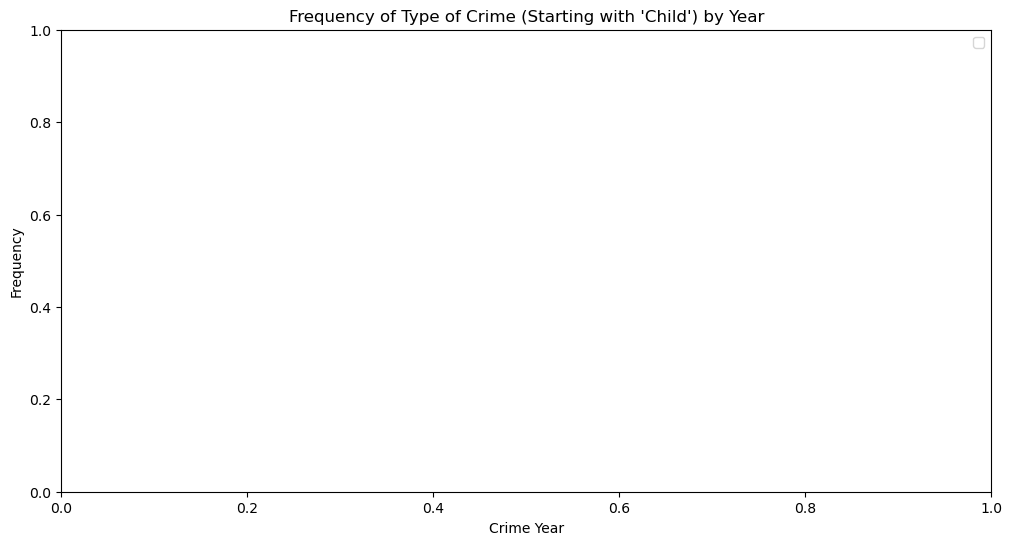

ValueError: Series.replace cannot use dict-like to_replace and non-None value

In [40]:
# Filter the data to include only "Type of Crime" that starts with "Child"

child_crimes = crime_frequency[crime_frequency['Type of Crime'].str.startswith('Child')]
# Set the figure size (optional)
plt.figure(figsize=(12, 6))
# Create a line plot for each "Type of Crime" that starts with "Child"
for crime_type, group in child_crimes.groupby('Type of Crime'):
    plt.plot(group['Crime Year'], group['Frequency'], label=crime_type)
# Add labels and legend
plt.xlabel("Crime Year")
plt.ylabel("Frequency")
plt.title("Frequency of Type of Crime (Starting with 'Child') by Year")
plt.legend()
# Show the plot
plt.show()
# Create a mapping of values to new categories
mapping = {
    "BATTERY - SIMPLE ASSAULT": "BATTERY",
    "BATTERY WITH SEXUAL CONTACT": "BATTERY",
    "CHILD ABANDONMENT": "CHILD CRIMES",
    "CHILD ABUSE (PHYSICAL) - AGGRAVATED ASSAULT": "CHILD CRIMES",
    "CHILD ABUSE (PHYSICAL) - SIMPLE ASSAULT": "CHILD CRIMES",
    "CHILD ANNOYING (17YRS & UNDER)": "CHILD CRIMES",
    "CHILD NEGLECT (SEE 300 W.I.C)": "CHILD CRIMES",
    "CHILD PORNOGRAPHY": "CHILD CRIMES",
    "CHILD STEALING": "CHILD CRIMES",
    "CRM AGNST CHLD (13 OR UNDER) (14-15 & SUSP 10 YRS OLDER)": "CHILD CRIMES"
}
# Use the replace function to map values to new categories
Data_complete['Type of Crime'] = Data_complete['Type of Crime'].replace(mapping, "OTHER")

In [ ]:
# Make a data frame with Columns for Average crime per area




filtered_data = Data_complete[Data_complete['Crime Location'] != 'RESIDENTIAL']
frequency_by_year = filtered_data.groupby('Crime Year').size()

# Plot the results as a bar chart
frequency_by_year.plot(kind='bar')
plt.xlabel('Crime Year')
plt.ylabel('Frequency')
plt.title('Frequency of "NON RESIDENTIAL" by Crime Year')
plt.show()
# Display Data Frame



# Filter the data to include only "Type of Crime" that starts with "Child"
child_crimes = crime_frequency[crime_frequency['Type of Crime'].str.startswith('Child')]

# Set the figure size (optional)
plt.figure(figsize=(12, 6))

# Create a line plot for each "Type of Crime" that starts with "Child"
for crime_type, group in child_crimes.groupby('Type of Crime'):
    plt.plot(group['Crime Year'], group['Frequency'], label=crime_type)

# Add labels and legend
plt.xlabel("Crime Year")
plt.ylabel("Frequency")
plt.title("Frequency of Type of Crime (Starting with 'Child') by Year")
plt.legend()

# Show the plot
plt.show()

# Create a mapping of values to new categories
mapping = {
    "BATTERY - SIMPLE ASSAULT": "BATTERY",
    "BATTERY WITH SEXUAL CONTACT": "BATTERY",
    "CHILD ABANDONMENT": "CHILD CRIMES",
    "CHILD ABUSE (PHYSICAL) - AGGRAVATED ASSAULT": "CHILD CRIMES",
    "CHILD ABUSE (PHYSICAL) - SIMPLE ASSAULT": "CHILD CRIMES",
    "CHILD ANNOYING (17YRS & UNDER)": "CHILD CRIMES",
    "CHILD NEGLECT (SEE 300 W.I.C)": "CHILD CRIMES",
    "CHILD PORNOGRAPHY": "CHILD CRIMES",
    "CHILD STEALING": "CHILD CRIMES",
    "CRM AGNST CHLD (13 OR UNDER) (14-15 & SUSP 10 YRS OLDER)": "CHILD CRIMES"
}

# Use the replace function to map values to new categories
Data_complete['Type of Crime'] = Data_complete['Type of Crime'].replace(mapping, "OTHER")

# Now, the values have been replaced in the "Type of Crime" column

# Set the figure size (optional)
plt.figure(figsize=(12, 6))

# Group the data by "Type of Crime" and "Crime Year" and count the frequency
crime_counts = Data_complete.groupby(['Type of Crime', 'Crime Year']).size().unstack().fillna(0)

# Create a bar chart for each "Type of Crime"
for crime_type in crime_counts.columns:
    plt.bar(crime_counts.index, crime_counts[crime_type], label=crime_type)

# Add labels and legend
plt.xlabel("Crime Year")
plt.ylabel("Frequency")
plt.title("Type of Crime by Year")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()


Total Crimes for Hispanic Victims (Pre and Post COVID)

In [ ]:
# Load your pre and post-COVID data
pre_covid_data = pd.read_csv(data_2010_2019)
post_covid_data = pd.read_csv(data_2020_2023)

# Concatenate the data into one DataFrame 
Data_complete = pd.concat([pre_covid_data, post_covid_data], ignore_index=True)

# Filter the data for Hispanic race# Filter the data for Hispanic ethnicity ('H') in the 'Vict Descent' column
hispanic_data = Data_complete[Data_complete['Vict Descent'] == 'H']
# Ensure 'DATE OCC' is in datetime format
hispanic_data['DATE OCC'] = pd.to_datetime(hispanic_data['DATE OCC'])

# Extract the year from 'DATE OCC' and store it in a new column 'Crime Year'
hispanic_data['Crime Year'] = hispanic_data['DATE OCC'].dt.year

# Group the data by 'Crime Year' and count the number of crimes
crime_counts = hispanic_data.groupby('Crime Year').size()

# Group the data by year and count the number of crimes
crime_counts = hispanic_data.groupby('Crime Year').size()

# Plot a line graph to visualize the total crimes over the years
plt.figure(figsize=(10, 6))
plt.plot(crime_counts.index, crime_counts.values, marker='o', linestyle='-', color='b')
plt.title('Total Crimes for Hispanic Victims (Pre and Post COVID)')
plt.xlabel('Year')
plt.ylabel('Total Crimes')
plt.grid(True)
plt.xticks(crime_counts.index, rotation=45)
# Show the plot
plt.show()